In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import copy
# 从训练集的50000个样本中，取49000个作为训练集，剩余1000个作为验证集
NUM_TRAIN = 49000

# 数据预处理，减去cifar-10数据均值
transform_normal = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
])
# 数据增强
transform_aug = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 加载训练集
cifar10_train = dset.CIFAR10('./dataset', train=True, download=True, transform=transform_normal)
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# 加载验证集
cifar10_val = dset.CIFAR10('./dataset', train=True, download=True, transform=transform_normal)
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

# 加载测试集
cifar10_test = dset.CIFAR10('./dataset', train=False, download=True, transform=transform_normal)
loader_test = DataLoader(cifar10_test, batch_size=64)
USE_GPU = True
dtype = torch.float32
print_every = 100

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [14]:
# 验证模型在验证集或者测试集上的准确率
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()   # set model to evaluation mode
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _,preds = scores.max(1)
            num_correct += (preds==y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 *acc ))
        return acc
def train_model(model, optimizer, accs,model_name,epochs=1, scheduler=None):
    '''
    Parameters:
    - model: A Pytorch Module giving the model to train.
    - optimizer: An optimizer object we will use to train the model
    - epochs: A Python integer giving the number of epochs to train
    Returns: best model
    '''
    best_model_wts = None
    best_acc = 0.0
    model = model.to(device=device) # move the model parameters to CPU/GPU
    for e in range(epochs):
        if scheduler:
            scheduler.step()
        for t,(x,y) in enumerate(loader_train):
            model.train()   # set model to training mode
            x = x.to(device, dtype=dtype)
            y = y.to(device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch %d, loss=%.4f' % (e, loss.item()))
        acc = check_accuracy(loader_val, model)
        accs.append(acc*100)
        if acc > best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            best_acc = acc
    print('best_acc:',best_acc)
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), model_name)
    return model

In [15]:
# 训练更多代数，并应用学习率衰减
cifar10_train = dset.CIFAR10('./dataset', train=True, download=True, transform=transform_aug)
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
learning_rate = 1e-2
accs=[]
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=10) # 假设目标有10类
optimizer = optim.SGD(vgg16.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15,gamma=0.1)
best_model= train_model(vgg16, optimizer,accs,'vgg16.pth',50, scheduler)
val_acc=check_accuracy(loader_test, best_model)

Epoch 0, loss=0.3781
Checking accuracy on validation set
Got 832 / 1000 correct (83.20)
Epoch 1, loss=0.5726
Checking accuracy on validation set
Got 826 / 1000 correct (82.60)
Epoch 2, loss=0.3884
Checking accuracy on validation set
Got 855 / 1000 correct (85.50)
Epoch 3, loss=0.3043
Checking accuracy on validation set
Got 881 / 1000 correct (88.10)
Epoch 4, loss=0.1947
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)
Epoch 5, loss=0.2133
Checking accuracy on validation set
Got 884 / 1000 correct (88.40)
Epoch 6, loss=0.2020
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)
Epoch 7, loss=0.2235
Checking accuracy on validation set
Got 908 / 1000 correct (90.80)
Epoch 8, loss=0.1991
Checking accuracy on validation set
Got 891 / 1000 correct (89.10)
Epoch 9, loss=0.1695
Checking accuracy on validation set
Got 892 / 1000 correct (89.20)
Epoch 10, loss=0.3217
Checking accuracy on validation set
Got 896 / 1000 correct (89.60)
Epoch 11, loss=0.0239
Checking 

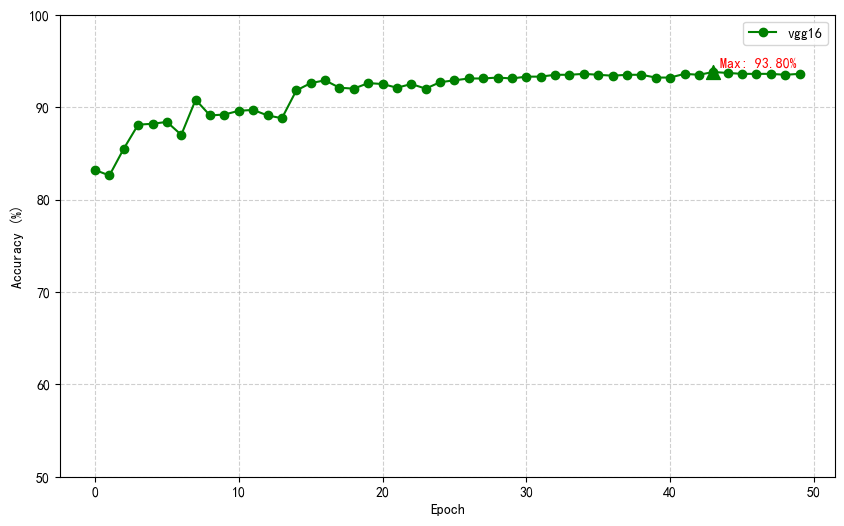

In [19]:
import matplotlib.pyplot as plt
# 设置字体为 SimHei（黑体），解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
epochs = np.arange(0,50 )
# 计算每条曲线最大值位置
max_idx = np.argmax(accs)

plt.figure(figsize=(10,6))

# 绘制三条曲线
plt.plot(epochs, accs, '-o', color='green', label='vgg16')

# 标注最大值点
plt.scatter(epochs[max_idx], accs[max_idx], color='green', s=100, marker='^')

# 调整最大值标签位置，避免重叠
plt.text(epochs[max_idx]+0.5, accs[max_idx]+0.5, f"Max: {accs[max_idx]:.2f}%", color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(50, 100)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('vgg16.png')
plt.show()